# Difussion equation

Solving the poisson equation $u_t-\Delta u = f$ using a physics informed neural network in multi dim.

![flow_learn_diagram](https://user-images.githubusercontent.com/35903705/90431457-b2ebd800-e08e-11ea-9bdd-dde98b2673f7.jpg)

### Manufactured solution


We use $u = t\sin (x+y)$ for $x \in X_1\times X_2$, $t\in[t_1,t_2]$ to manufacture the rhs of the difussion equation above.

### Importing packages

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import os

import DataProcess
import FluidModels
import Losses

### Manufacturing data for trainig

In [2]:
np.random.seed(123)
pde_data_size = 2000
bc_data_size = 400

#domain range
X_1_domain = [-2, 2]
X_2_domain = [0, 1]
#time range
T_initial = 0
T_final = 1
T_domain = [T_initial, T_final]

#space data
space_dim = 2
X_1_tr_pde = np.random.uniform(X_1_domain[0], X_1_domain[1], pde_data_size).reshape(pde_data_size,1)
X_2_tr_pde = np.random.uniform(X_2_domain[0], X_2_domain[1], pde_data_size).reshape(pde_data_size,1)
# X_tr_pde = np.random.uniform(-1,1,pde_data_size*space_dim).reshape(pde_data_size,space_dim)

#temporal data
X_tr_time = np.random.uniform(T_initial, T_final, pde_data_size).reshape(pde_data_size,1)

X_tr_pde = np.concatenate([X_1_tr_pde, X_2_tr_pde, X_tr_time],axis=1)
X_1_tr_pde.shape

(2000, 1)

In [3]:
X_tr_pde.shape

(2000, 3)

### Looking at the scatter plot of data

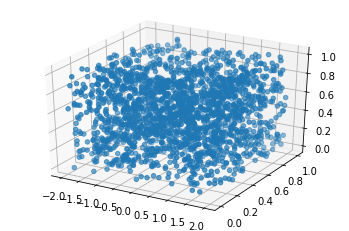

In [4]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_tr_pde[:,0],X_tr_pde[:,1],X_tr_pde[:,2])


### Defining the labels(true values) for the training data

In [5]:
Y_tr_pde = np.zeros((X_tr_pde.shape[0],1))
# Y_tr_pde = X_tr_pde[:,0:1]


In [6]:
Y_tr_pde = np.concatenate([Y_tr_pde,np.zeros((Y_tr_pde.shape[0],1))],axis=1)
Y_tr_pde.shape

(2000, 2)

## BC data 

In [7]:
# bc_data_size = 100

X_bc_left = np.random.uniform(X_2_domain[0],X_2_domain[1],
                              bc_data_size).reshape(bc_data_size,1)
X_bc_left = np.concatenate([X_1_domain[0]*np.ones((bc_data_size,1)),
                            X_bc_left], axis=1)
X_bc_left = np.concatenate([X_bc_left,
                            np.random.uniform(T_initial, T_final, bc_data_size).reshape(bc_data_size,1)], 
                            axis=1)

X_bc_bottom = np.random.uniform(X_1_domain[0],X_1_domain[1],
                                bc_data_size).reshape(bc_data_size,1)
X_bc_bottom = np.concatenate([X_bc_bottom, X_2_domain[0]*np.ones((bc_data_size,1))],
                             axis=1)
X_bc_bottom = np.concatenate([X_bc_bottom,
                              np.random.uniform(T_initial, T_final, bc_data_size).reshape(bc_data_size,1)], axis=1)

X_bc_right = np.random.uniform(X_2_domain[0],X_2_domain[1],
                              bc_data_size).reshape(bc_data_size,1)
X_bc_right = np.concatenate([X_1_domain[1]*np.ones((bc_data_size,1)),
                            X_bc_right], axis=1)
X_bc_right = np.concatenate([X_bc_right,
                            np.random.uniform(T_initial, T_final, bc_data_size).reshape(bc_data_size,1)], 
                            axis=1)

X_bc_top = np.random.uniform(X_1_domain[0],X_1_domain[1],
                                bc_data_size).reshape(bc_data_size,1)
X_bc_top = np.concatenate([X_bc_top, X_2_domain[1]*np.ones((bc_data_size,1))],
                          axis=1)
X_bc_top = np.concatenate([X_bc_top,
                            np.random.uniform(T_initial, T_final, bc_data_size).reshape(bc_data_size,1)], 
                            axis=1)

X_bc = np.concatenate([X_bc_left, X_bc_bottom, X_bc_right, X_bc_top],axis=0)

#Add iniital condition below: add them to be X_ic and finallly concatenate bc and ic to get X_bc_ic
X_ic = np.random.uniform(X_1_domain[0],X_1_domain[1],
                                bc_data_size).reshape(bc_data_size,1)
X_ic = np.concatenate([X_ic, np.random.uniform(X_2_domain[0],X_2_domain[1],
                              bc_data_size).reshape(bc_data_size,1)],
                          axis=1)
X_ic = np.concatenate([X_ic,
                            T_initial*np.ones((bc_data_size,1))], 
                            axis=1)

In [8]:
X_bc_ic = np.concatenate([X_bc, X_ic],axis=0)

In [9]:
X_bc_ic

array([[-2.        ,  0.04296696,  0.24703121],
       [-2.        ,  0.28069545,  0.48657334],
       [-2.        ,  0.47581722,  0.76460359],
       ...,
       [-1.4357224 ,  0.98514494,  0.        ],
       [ 1.05569936,  0.22066212,  0.        ],
       [ 0.00442776,  0.61329717,  0.        ]])

In [10]:
Y_bc_ic = np.sin(X_bc_ic[:,0:1] + X_bc_ic[:,1:2]) * X_bc_ic[:,2:3]
# Y_bc = np.concatenate([Y_bc, np.ones((Y_bc.shape[0],1))], axis=1 )

### Saving the data to a csv file

In [11]:
combined_data = np.concatenate([X_bc_ic,Y_bc_ic],axis=1)

In [12]:
DataProcess.save_to_csv(combined_data, "data_manufactured/t_sin_x_plus_y")

In [13]:
X_data, Y_data = DataProcess.imp_from_csv("data_manufactured/t_sin_x_plus_y.csv",
                                             True,1)

In [14]:
data_processor = DataProcess.Data_preprocess(2, dom_bounds=[X_1_domain,X_2_domain,T_domain], time_dep=True)

In [15]:
X_tr, Y_tr = data_processor.get_training_data(X_data,Y_data, X_col_points=pde_data_size)

In [16]:
# X_tr = np.concatenate((X_tr_pde, X_bc), axis=0)
# Y_tr = np.concatenate((Y_tr_pde, Y_bc), axis=0)

## Training the model

In [17]:
import FluidModels

In [18]:

def rhs_function (args, time_dep=True):
        if time_dep:
            space_inputs = args[:-1]
            time_inputs = args[-1]
        else:
            space_inputs = args
        
        return tf.sin(space_inputs[0]+space_inputs[1]) + 2*time_inputs*tf.sin(space_inputs[0]+space_inputs[1])

In [19]:
pinn_model = FluidModels.ForwardModel(space_dim=2, time_dep=True, rhs_func = rhs_function)
# pinn_model = FluidModels.ForwardModel(space_dim=2, time_dep=True, rhs_func = None)

In [20]:
# #Loss coming from the boundary terms
# def u_loss(y_true, y_pred):
# #     print("\n\nreached here 1 \n\n\n")
#     y_true_act = y_true[:,:-1]
#     at_boundary = tf.cast(y_true[:,-1:,],bool)
#     u_sq_error = (1/2)*tf.square(y_true_act-y_pred)
# #     print("\n\nreached here 2 \n\n\n")
# #     print("\nu_loss: ",tf.where(at_boundary, u_sq_error, 0.))
#     return tf.where(at_boundary, u_sq_error, 0.)

# #Loss coming from the PDE constrain
# def pde_loss(y_true, y_pred):
#     y_true_act = y_true[:,:-1]
#     at_boundary = tf.cast(y_true[:,-1:,],bool)
#     #need to change this to just tf.square(y_pred) after pde constrain is added to grad_layer
#     pde_sq_error = (1/2)*tf.square(y_pred)
# #     print("\npde_loss: ",tf.where(at_boundary,0.,pde_sq_error))
#     return tf.where(at_boundary,0.,pde_sq_error)

In [21]:
# loss_1 = Losses.u_loss
# loss_2 = Losses.pde_loss

In [22]:
pinn_model.compile(loss=[Losses.u_loss, Losses.pde_loss], optimizer="adam")
# pinn_model.compile(loss=u_loss, optimizer=keras.optimizers.SGD(lr=1e-3))

## Using tensor board for visualization

In [23]:
# import os
# root_logdir = os.path.join(os.curdir, "tensor_logs")

# def get_run_logdir():
#     import time
#     run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
#     return os.path.join(root_logdir, run_id)

# run_logdir = get_run_logdir() # e.g., './my_logs/run_2019_06_07-15_15_22'

In [24]:
# tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

In [26]:
# pinn_model.fit(x=[X_tr[:,0:1], X_tr[:,1:2], X_tr[:,2:3]], y=[Y_tr, Y_tr], epochs=10)
fit = pinn_model.fit(x=X_tr, y=[Y_tr, Y_tr], epochs=10)

Epoch 1/10
125/125 [==============================] - 1s 9ms/step - loss: 0.0025 - output_1_loss: 9.3394e-04 - output_2_loss: 0.0016
Epoch 2/10
125/125 [==============================] - 1s 9ms/step - loss: 0.0021 - output_1_loss: 8.4185e-04 - output_2_loss: 0.0013
Epoch 3/10
125/125 [==============================] - 1s 9ms/step - loss: 0.0018 - output_1_loss: 7.6065e-04 - output_2_loss: 0.0010
Epoch 4/10
125/125 [==============================] - 1s 9ms/step - loss: 0.0016 - output_1_loss: 7.0983e-04 - output_2_loss: 8.6379e-04
Epoch 5/10
125/125 [==============================] - 1s 9ms/step - loss: 0.0013 - output_1_loss: 6.3752e-04 - output_2_loss: 7.0662e-04
Epoch 6/10
125/125 [==============================] - 1s 9ms/step - loss: 0.0012 - output_1_loss: 5.9333e-04 - output_2_loss: 6.3073e-04
Epoch 7/10
125/125 [==============================] - 1s 10ms/step - loss: 0.0011 - output_1_loss: 5.8547e-04 - output_2_loss: 4.9338e-04
Epoch 8/10
125/125 [==============================] 

In [27]:
# %load_ext tensorboard
# %tensorboard --logdir=./tensor_logs --port=9009

In [28]:
# pinn_model.compile(loss=[u_loss,pde_loss], optimizer=keras.optimizers.SGD(lr=1e-4))
# pinn_model.fit(x=[X_tr[:,0:1], X_tr[:,1:2]], y=[Y_tr, Y_tr], epochs=10)

In [29]:
pinn_model.summary()

Model: "forward_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              multiple                  80        
_________________________________________________________________
dense_2 (Dense)              multiple                  420       
_________________________________________________________________
dense_3 (Dense)              multiple                  420       
_________________________________________________________________
final_layer (Dense)          multiple                  21        
Total params: 941
Trainable params: 941
Non-trainable params: 0
_________________________________________________________________


In [30]:
# history = pinn_model.evaluate(x=X_tr, y=Y_tr)

In [31]:
history

import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import os

import DataProcess
import FluidModels
import Losses
np.random.seed(123)
pde_data_size = 2000
bc_data_size = 400

#domain range
X_1_domain = [-2, 2]
X_2_domain = [0, 1]
#time range
T_initial = 0
T_final = 1
T_domain = [T_initial, T_final]

#space data
space_dim = 2
X_1_tr_pde = np.random.uniform(X_1_domain[0], X_1_domain[1], pde_data_size).reshape(pde_data_size,1)
X_2_tr_pde = np.random.uniform(X_2_domain[0], X_2_domain[1], pde_data_size).reshape(pde_data_size,1)
# X_tr_pde = np.random.uniform(-1,1,pde_data_size*space_dim).reshape(pde_data_size,space_dim)

#temporal data
X_tr_time = np.random.uniform(T_initial, T_final, pde_data_size).reshape(pde_data_size,1)

X_tr_pde = np.concatenate([X_1_tr_pde, X_2_tr_pde, X_tr_time],axis=1)
X_1_tr_pde.shape
X_tr_pde.shape
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_

### Testing the model

In [32]:
# X_test_st = np.random.uniform(-0.5,0.5,20*dim_d).reshape(20,dim_d)

In [33]:
#space test data
test_dat_size = 100
X_test_st = np.random.uniform(X_1_domain[0],X_1_domain[1],test_dat_size).reshape(test_dat_size,1)
X_test_st = np.concatenate([X_test_st, np.random.uniform(X_2_domain[0],X_2_domain[1],test_dat_size).reshape(test_dat_size,1)], axis=1)
#temporal test data
X_test_time = np.random.uniform(T_initial,T_final,test_dat_size).reshape(test_dat_size,1)

X_test_st = np.concatenate([X_test_st, X_test_time],axis=1)


In [34]:
X_test_st = data_processor.prepare_input_data(X_test_st)

In [35]:
# Y_test = pinn_model.predict(x=[X_test_st[:,0:1], X_test_st[:,1:2], X_test_st[:,2:3]])
# pinn_model.predict(x=[X_tr[0:40,0:1], X_tr[0:40,1:2], X_tr[0:40,2:3]]) [0]
Y_test = pinn_model.predict(x=X_test_st)
len(Y_test)

2

In [54]:
Y_test_true = np.sin(X_test_st[0] + X_test_st[1]) * X_test_st[2]
Y_test_true_vel = np.cos(X_test_st[0] + X_test_st[1]) * X_test_st[2]
Y_eval = np.concatenate([Y_test_true,np.ones((Y_test_true.shape[0],1))], axis=1)

In [55]:
# pinn_model.evaluate(x=[X_test_st[:,0:1], X_test_st[:,1:2]], y= Y_eval)

In [56]:
np.concatenate([Y_test_true, Y_test[0]], axis=1)

array([[ 0.27601219,  0.25110584],
       [ 0.14540243,  0.13727956],
       [-0.38059227, -0.36432955],
       [-0.40799745, -0.39165133],
       [ 0.02298886, -0.07582398],
       [ 0.64894173,  0.60711354],
       [ 0.49922989,  0.54119313],
       [-0.11370791, -0.12100726],
       [-0.31794843, -0.30296499],
       [-0.87317673, -0.93800956],
       [ 0.80453291,  0.76983076],
       [-0.47175663, -0.43598923],
       [ 0.66300287,  0.64504224],
       [ 0.362959  ,  0.31129819],
       [ 0.68610531,  0.66352993],
       [-0.09642737, -0.0956054 ],
       [ 0.49248678,  0.52322143],
       [ 0.29811447,  0.29887995],
       [ 0.41634705,  0.38965052],
       [-0.49375492, -0.47855073],
       [-0.69224581, -0.67735201],
       [ 0.08755652,  0.1236942 ],
       [-0.01084662, -0.05724512],
       [ 0.22713209,  0.21716835],
       [ 0.70514958,  0.66623622],
       [ 0.81659489,  0.80328172],
       [ 0.14756666,  0.12776671],
       [ 0.30966985,  0.2753861 ],
       [ 0.01019387,

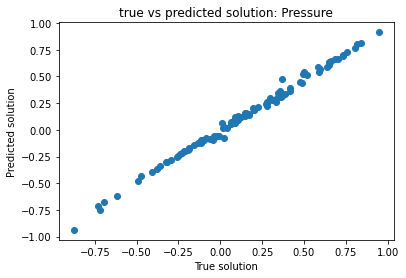

In [57]:
plt.scatter(Y_test_true,Y_test[0])
plt.title("true vs predicted solution: Pressure")
plt.xlabel("True solution")
plt.ylabel("Predicted solution")
plt.show()

In [58]:
Y_test[1][0][0].shape

(100, 1)

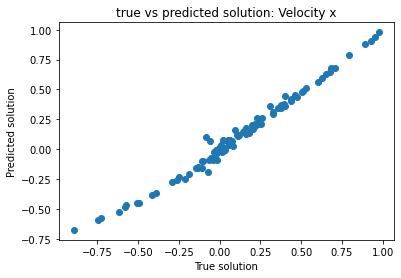

In [59]:
plt.scatter(Y_test_true_vel,Y_test[1][0][0])
plt.title("true vs predicted solution: Velocity x")
plt.xlabel("True solution")
plt.ylabel("Predicted solution")
plt.show()

## Saving and loading the trained FluidLearn model

### Saving the model

In [25]:
os.makedirs("./saved_models", exist_ok=True)

#Saving the model using .h5 extension
pinn_model.save("./saved_models/trained_model_1")


INFO:tensorflow:Assets written to: ./saved_models_2/trained_model_1/assets


In [38]:
# loaded_model = keras.models.load_model("./save_models/trained_model_1",
#                                       custom_objects={"space_dim": space_dim, 
#                 "time_dep": time_dep, "output_dim": output_dim,
#                  "n_hid_lay": n_hid_lay, "n_hid_nrn": n_hid_nrn,
#                 "act_func": act_func})
    loaded_model = keras.models.load_model("./saved_models/trained_model_1",
                                          custom_objects={"u_loss": Losses.u_loss,
                                                         "pde_loss": Losses.pde_loss})


In [39]:
new_predicted_test=loaded_model.predict(x=X_test_st)

In [40]:
np.concatenate([Y_test,new_predicted_test], axis=1)

array([[ 0.25523862,  0.25523862],
       [ 0.12629034,  0.12629034],
       [-0.34698167, -0.34698167],
       [-0.37192294, -0.37192294],
       [-0.12948751, -0.12948751],
       [ 0.5485113 ,  0.5485113 ],
       [ 0.5945483 ,  0.5945483 ],
       [-0.11641303, -0.11641303],
       [-0.2874321 , -0.2874321 ],
       [-0.8821924 , -0.8821924 ],
       [ 0.722512  ,  0.722512  ],
       [-0.3887959 , -0.3887959 ],
       [ 0.59087133,  0.59087133],
       [ 0.27543485,  0.27543485],
       [ 0.63271695,  0.63271695],
       [-0.09031705, -0.09031705],
       [ 0.5781835 ,  0.5781835 ],
       [ 0.2798178 ,  0.2798178 ],
       [ 0.35892668,  0.35892668],
       [-0.44289055, -0.44289055],
       [-0.62416124, -0.62416124],
       [ 0.12334868,  0.12334868],
       [-0.06602845, -0.06602845],
       [ 0.19845653,  0.19845653],
       [ 0.61451155,  0.61451155],
       [ 0.71627766,  0.71627766],
       [ 0.11241148,  0.11241148],
       [ 0.23309457,  0.23309457],
       [ 0.08702155,

In [41]:
loaded_model.fit(x=X_tr, y=[Y_tr, Y_tr], epochs=1)

125/125 [==============================] - 1s 8ms/step - loss: 0.0035 - output_1_loss: 0.0015 - output_2_loss: 0.0020


![flow_learn_diagram](https://user-images.githubusercontent.com/35903705/90431457-b2ebd800-e08e-11ea-9bdd-dde98b2673f7.jpg)

## Creating class for generating boundary conditions

In [1]:
import numpy as np

In [43]:
class BcIcDataManufact:
    """
    Class to generate Boundary and Initial Condition Data.
    """
    def __init__(self, dom_bounds):
        """
        Attributes:
        dom_bounds (list of lists) - list of  list, where each
        element list is an intervel giving bound for interval from
        which random points needs to be generated.
        dim = dimension of the space where the points are generated
        """
        self.__dom_bounds = dom_bounds
        self.__dim = len(dom_bounds)
        
        
    def generate_uniform_data(self, dom_bounds, n):
        """
        Generates uniformly distributed points in intervals defined by dom_bounds
        
        Arguments:
        dom_bounds (list of lists) - list of  list, where each
        element list is an intervel giving bound for interval from
        which random points needs to be generated.
        n (int) - number of data points to be generated from each interval
        
        Return: np.ndarray of shape (n,len(dom_bounds))
        """
        generated_data = np.zeros((n,len(dom_bounds)))
        
        for i in range(len(dom_bounds)):
            generated_data[:,i] = np.random.uniform(low=dom_bounds[i][0],
                                                   high=dom_bounds[i][1],
                                                   size=n)
        return generated_data
    
    def generate_uniform_bc_ic(self, n):
        """
        Generates uniformly distributed boundary/Initial condition points
        lying on the boundary of hypercube defined by the intervals stored 
        in self.__dom_bounds
        
        Arguments:
        n (int) - number of data points to be generated from each part of
        the boundary.
        
        Return: np.ndarray of shape (k*n,self.__dim), where k 
        is the number of faces(boundaries) of the hypercube which is indeed
        equal to 2*dim.
        """
        #allocating space for the output ndarray
        generated_data = np.zeros((2*self.__dim*n,self.__dim))
        
        #to keep track of where to add elements in generated_data
        entry_index = 0 
        
        for dim_i in range(self.__dim): #going over each element in self.__dom_bound
            for j in range(2): #to iterate over lower and upper bound
                generated_sub_data = self.generate_uniform_data(self.__dom_bounds, n)
    
                #Making the appropriate column corresponding to boudnayr condition,
                #x_i = upper/lower bound
                generated_sub_data[:,dim_i] = self.__dom_bounds[dim_i][j]*np.ones(n)
                
                #finally adding the generated bc/ic to final output array
                generated_data[entry_index:entry_index+n,:] = generated_sub_data
                
                entry_index += n
        
        return generated_data
        

In [46]:
dom_bounds = [[0,4],[-10,10],[100,400]]
# dom_bounds = [[0,4],[-10,10]]
data_gen = BcIcDataManufact(dom_bounds)

In [57]:
data_gen.generate_uniform_bc_ic(4)

array([[ 0.00000000e+00,  9.50347875e+00,  2.50161086e+02],
       [ 0.00000000e+00, -4.48454653e+00,  3.79277041e+02],
       [ 0.00000000e+00, -1.61914177e+00,  2.82628171e+02],
       [ 0.00000000e+00, -7.01665973e+00,  2.33695908e+02],
       [ 4.00000000e+00, -7.56372069e+00,  2.33382063e+02],
       [ 4.00000000e+00,  2.92679889e+00,  3.62948567e+02],
       [ 4.00000000e+00, -2.90052315e+00,  2.84367323e+02],
       [ 4.00000000e+00,  6.86134310e+00,  3.89204475e+02],
       [ 1.98764418e+00, -1.00000000e+01,  3.58389028e+02],
       [ 2.78595440e+00, -1.00000000e+01,  1.45766110e+02],
       [ 1.78722174e+00, -1.00000000e+01,  3.07758107e+02],
       [ 2.78485496e+00, -1.00000000e+01,  2.32871352e+02],
       [ 1.44176878e+00,  1.00000000e+01,  1.48094839e+02],
       [ 3.06009776e+00,  1.00000000e+01,  1.57893701e+02],
       [ 2.49446942e+00,  1.00000000e+01,  2.78440673e+02],
       [ 2.87549317e-01,  1.00000000e+01,  2.66162642e+02],
       [ 1.66341673e+00,  1.42060456e+00

In [30]:
dom_bounds = [[0,4],[-10,10],[100,400]]
data = data_gen.generate_uniform_data(dom_bounds, 5)
data

array([[  2.47752523,  -8.1319419 , 162.22961052],
       [  1.71536612,   1.63607556, 382.68388834],
       [  0.58291772,   2.79663019, 393.06020976],
       [  1.97114857,  -9.71022968, 267.65181066],
       [  2.64308867,   9.51026909, 315.14706271]])

In [ ]:
data = np.concatenate([data])

In [29]:
data[0:2,].shape

IndexError: too many indices for array